In [52]:
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff

# GLOBALS
torch.manual_seed(0)

In [53]:
def prior(N, D, mu=0, sigma=1.0, shuffle=True, modify=False, dimensions_to_modify=None, percentage_to_modify=None) -> torch.Tensor:
    '''
    Each dimension will have a mean of mu and a standard deviation of sigma.
    The prior is assumed to be a Gaussian distribution.
    '''
    particles = torch.normal(mean=mu, std=sigma, size=(N, D))

    if shuffle:
        indices = torch.randperm(N)
        particles = particles[indices]

    if modify:
        particles = prior_modification(particles, dimensions_to_modify, percentage_to_modify)
    
    return particles


def prior_modification(particles, dimension_to_modify, percentage_to_modify):
    '''
    Manual modification of the prior
    '''
    particles_modified = particles.clone()

    # base cases
    if percentage_to_modify is None:
        percentage_to_modify = 0.3 # modify 30% of the particles

    if dimension_to_modify is None:
        dimension_to_modify = 0 # select dimension 0

    modified_dimension_value = 0 # set the new dimension value to 0

    # modify the particles
    num_particles_to_modify = int(particles.shape[0] * percentage_to_modify)
    particles_modified[:num_particles_to_modify, dimension_to_modify] = modified_dimension_value

    return particles_modified


def transition(states):
    """
    The transition model.
    We will just add a small noise to each dimension of each state.
    """
    noise = torch.normal(mean=0, std=0.1, size=states.shape)
    return states + noise

    
def likelihood(state, dimensions):
    """
    Returns Euclidean distance to a specific target point
    """
    target = torch.tensor([0.5] * dimensions) # target point at the center
    square_diff = (state - target) ** 2
    return torch.sqrt(square_diff.sum(dim=-1))


def smc(prior, timesteps, num_samples):
    """
    The SMC loop
    """

    dimensions = prior.shape[-1]

    for t in tqdm.tqdm(range(timesteps)):
        proposed_states = transition(states=prior)
        # we will apply the negative exponential to convert distances into weights,
        # which results in a higher weight to closer states because the close distance results in a large exponential value
        weights = torch.exp(-likelihood(proposed_states, dimensions))
        weights /= weights.sum() # normalize weights
        indices = torch.multinomial(weights, num_samples=num_samples, replacement=True) # resampling
        states = proposed_states[indices]

    return states


def fuzz_test(particles):
    '''
    This function will test if a batch of particles satisfies the following criteria:
    
    Steps:
    1. Each particle will be tested

    Criteria:
    For each particle:
    - if the first dimension is 0, add 1 to the counter

    The count represents the number of particles that pass the fuzz test
    '''
    count = 0
    for particle in particles:
        # if particle[0] is within the range of -0.5 and 0.5, add 1 to the counter
        if particle[0] >= -0.5 and particle[0] <= 0.5:
            count += 1
    return count

In [54]:
# generate N prior samples
prior_samples = prior(N=100, D=3, modify=False)
prior_samples_modified = prior(N=100, D=3, modify=True)

print("Prior samples:")
print(prior_samples[:3])
# print('Shape:', prior_samples.shape)
print()
print("Prior samples (modified):")
print(prior_samples_modified[:3])
# print('Shape:', prior_samples_modified.shape)

Prior samples:
tensor([[-1.0335, -0.3126,  0.2458],
        [-1.0922,  0.3920,  0.5945],
        [ 2.3022, -1.4689, -1.5867]])

Prior samples (modified):
tensor([[ 0.0000,  1.4585,  2.2557],
        [ 0.0000,  1.9733, -0.2075],
        [ 0.0000, -1.5627, -0.8733]])


In [55]:
# fuzz test the prior samples
print()
print("Fuzz test (prior samples):")
print(fuzz_test(prior_samples))
print()
print("Fuzz test (prior samples modified):")
print(fuzz_test(prior_samples_modified))


Fuzz test (prior samples):
39

Fuzz test (prior samples modified):
59


In [56]:
# distribution of non-modified (normal-gaussian) prior

# for loop to get the data from each dimension if more than 1 dimension
data = []
group_labels = []
for i in range(prior_samples.shape[1]):
    data.append(prior_samples[:, i].numpy())
    group_labels.append(f'Dimension {i}')

fig = ff.create_distplot(data, group_labels, bin_size=0.2)
fig.update_layout(title='Prior Distribution')
fig.show()

In [57]:
# distribution of modified prior

# for loop to get the data from each dimension if more than 1 dimension
data = []
group_labels = []

for i in range(prior_samples_modified.shape[1]):
    data.append(prior_samples_modified[:, i].numpy())
    group_labels.append(f'Dimension {i}')

fig = ff.create_distplot(data, group_labels, bin_size=0.2)
fig.update_layout(title='Prior Distribution (Modified)')
fig.show()

In [58]:
# plotly surface plot for the prior
fig = go.Figure(data=[go.Surface(z=prior_samples.numpy())])
# set z axis range
fig.update_layout(scene = dict(zaxis = dict(range=[-5,5])))
fig.update_layout(title='Prior')
fig.show()

In [59]:
# plotly surface plot for the prior (modified)
fig = go.Figure(data=[go.Surface(z=prior_samples_modified.numpy())])
# set z axis range
fig.update_layout(scene = dict(zaxis = dict(range=[-5,5])))
fig.update_layout(title='Prior (modified)')
fig.show()

In [60]:
# Params
DIMENSIONS = 10 # State dimension
N_prior = 10 # initial number of particles
MU = 0.0 # Mean of the prior
SIGMA = 1.0 # Variance of the prior

TIMESTEPS = 1000 # Number of timesteps
N_smc = 1000 # Number of particles for SMC to generate

# Generate particles from prior
particles_prior = prior(mu=MU, sigma=SIGMA, N=N_prior, D=DIMENSIONS, shuffle=True, modify=True)

# Run SMC
particles_posterior = smc(prior=particles_prior, timesteps=TIMESTEPS, num_samples=N_smc)

100%|██████████| 1000/1000 [00:00<00:00, 15177.40it/s]


In [61]:
# check size of prior and posterior
print('Prior size:', particles_prior.shape)
print('Posterior size:', particles_posterior.shape)

Prior size: torch.Size([10, 10])
Posterior size: torch.Size([1000, 10])


In [62]:
# fuzz test the prior and posterior
print("Fuzz test (prior):")
print(fuzz_test(particles_prior))
print()
print("Fuzz test (posterior):")
print(fuzz_test(particles_posterior))

Fuzz test (prior):
3

Fuzz test (posterior):
524


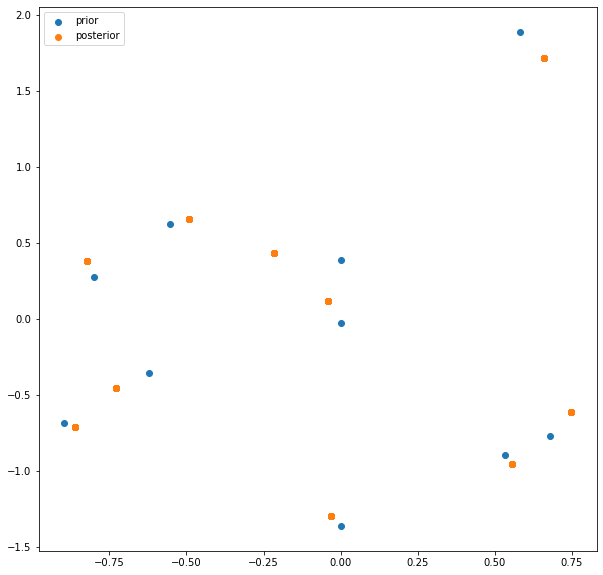

In [63]:
# Compare prior and posterior
plt.figure(figsize=(10, 10)) # size
plt.scatter(particles_prior[:, 0], particles_prior[:, 1], label='prior', )
plt.scatter(particles_posterior[:, 0], particles_posterior[:, 1], label='posterior')
plt.legend()
plt.show()

In [64]:
# plotly surface plot for the prior
fig = go.Figure(data=[go.Surface(z=particles_prior.numpy())])
# set z axis range
fig.update_layout(scene = dict(zaxis = dict(range=[-5,5])))
fig.update_layout(title='Prior Particles Distribution (First 3 Dimensions)')
fig.show()

In [65]:
# surface plot for the posterior
fig = go.Figure(data=[go.Surface(z=particles_posterior.numpy())])
# set z axis range
fig.update_layout(scene = dict(zaxis = dict(range=[-5,5])))
fig.update_layout(title='Posterior Particles Distribution (First 3 Dimensions)')
fig.show()